In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pprint

from qutip import * 
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$

$$
H_0 = \hbar \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)} + \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{ij} \sigma_+^{(i)} \sigma_-^{(j)} \quad \text{,} \quad J_{ij} = \frac{\alpha}{|r_i - r_j|^3}
$$

$$
H_I = \hbar D \cdot E(t)
\quad \text{,} \quad D = \mu \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} + \sigma_-^{(i)}
\quad \text{,} \quad E(t_i) \propto \Omega_{coupling} \cos(\pi (t - t_i)) \delta(t_i)
$$

### Decay operators single case
$$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$$

In [3]:
#
# Set the system parameters
#
# ENERGY LANDSCAPE, c = 1, hbar = 1
fixed_lam = 1. #
alpha     = 1. # coupling strength of the dipoles       Fine structure const?

omega_a   = 2 * np.pi / fixed_lam   # energysplitting of the atom, when ground state is set to 0
mu        = 1 * omega_a             # Dipole matrix element of each atom
omega_R   = 1 * omega_a                     # Rabi freq coupling to laser field  for first 2 lasers  -> E_field_0 dot dot Dip_op, parallel

# LINBLAD OPS
gamma_0   = .1 # decay rate of the atoms
gamma_phi = .1 # dephasing rate of the atoms

# TOPOLOGY
n_chains = 1 # number of chains
n_rings  = 1 # number of rings
N_atoms  = n_chains * n_rings  # number of atoms

distance = 1. # * fixed_lam # defining topology

# TIME EVOLUTION
last_pulse = 10 # * gamma_0
last_det_t = 1 * last_pulse # last time when the system is measured -> t elem 0...last_det_t - T
time_steps = 100
tau_steps = time_steps
T_steps = time_steps // 5
approx_T_vals = np.linspace(0, last_det_t, T_steps)  # approximate T values

times_t = np.linspace(0, last_det_t, time_steps) # list of times_t
T_indices = np.array([np.abs(times_t - x).argmin() for x in approx_T_vals])

taus = np.linspace(0, last_det_t, time_steps)  # list of times_t for tau
Ts = times_t[T_indices]
print(approx_T_vals, Ts)

[ 0.          0.52631579  1.05263158  1.57894737  2.10526316  2.63157895
  3.15789474  3.68421053  4.21052632  4.73684211  5.26315789  5.78947368
  6.31578947  6.84210526  7.36842105  7.89473684  8.42105263  8.94736842
  9.47368421 10.        ] [ 0.          0.50505051  1.01010101  1.61616162  2.12121212  2.62626263
  3.13131313  3.63636364  4.24242424  4.74747475  5.25252525  5.75757576
  6.36363636  6.86868687  7.37373737  7.87878788  8.38383838  8.98989899
  9.49494949 10.        ]


In [4]:
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos
def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])
def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos
def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos
################## help functions
def count_decimal_digits(number):
    # Convert the number to string
    str_number = str(number)

    # Split the string at the decimal point and count the digits after it
    if '.' in str_number:
        return len(str_number.split('.')[1])
    else:
        return 0  # No digits after decimal if it's an integer
tolerance = count_decimal_digits(times_t[1]) - 2
def truncate_number(number, decimals=0):
    factor = 10.0 ** decimals
    return int(number * factor) / factor
def heaviside(x):
    return 1 if x >= 0 else 0

mean_pos = [0, 0, 0]  # Mean position (can be any point in 3D space)
sigma_pos = N_atoms / 10  # Standard deviation for position distribution
def sample_positions(mean_pos, sigma_pos, N_atoms):
    positions = []
    while len(positions) < N_atoms:
        # Sample a new position for the atom
        new_position = np.random.normal(loc=mean_pos, scale=sigma_pos, size=3)
        # Check if the new position is unique (no duplicates)
        if not any(np.allclose(new_position, pos) for pos in positions):
            positions.append(new_position)
    return np.array(positions)
Delta = 0.0125 * omega_a  # Full Width at Half Maximum for Gaussian distribution
def sample_frequencies(E0, Delta, N_atoms):
    # Sample N_atoms frequencies from the Gaussian distribution
    frequencies = np.random.normal(loc=E0, scale=Delta/2, size=N_atoms)
    return frequencies

<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_21142/569296777.py:11: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Normalized Energy (E / $\omega_a$)')


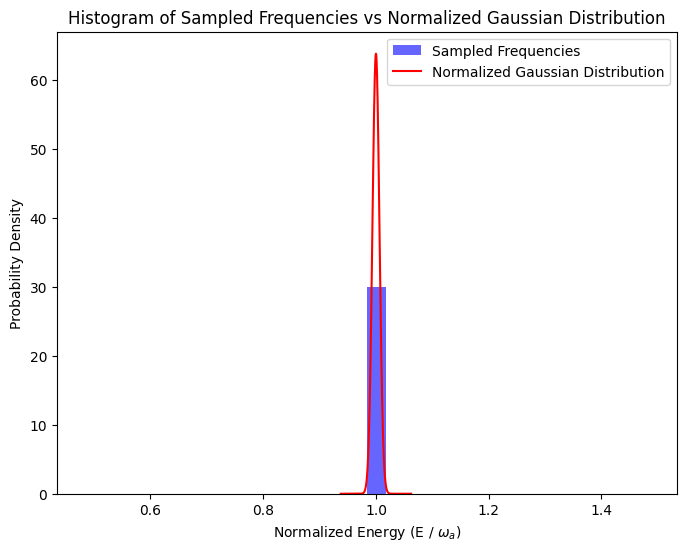

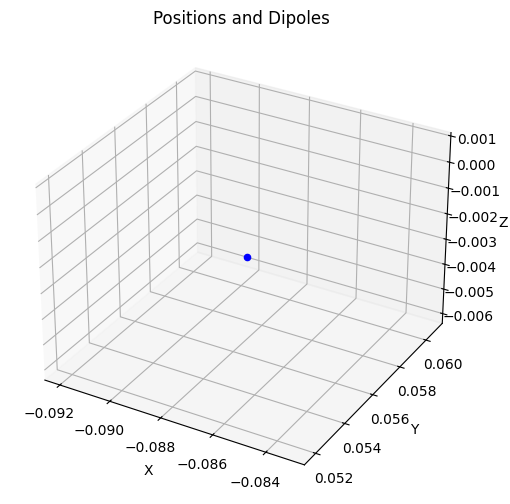

In [5]:
# Sample frequencies for each atom
atom_frequencies = sample_frequencies(1, Delta, N_atoms)

plt.figure(figsize=(8, 6))
E_normalized = np.linspace(omega_a - 5 * Delta, omega_a + 5 * Delta, 1000) / omega_a
sigma_normalized = Delta / (2 * omega_a)  # Standard deviation in normalized units
P_normalized = (1 / (sigma_normalized * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((E_normalized - 1) / sigma_normalized)**2)
plt.hist(atom_frequencies, bins=30, density=True, alpha=0.6, color='blue', label='Sampled Frequencies')
plt.plot(E_normalized, P_normalized, label=r'Normalized Gaussian Distribution', color='red')
plt.title('Histogram of Sampled Frequencies vs Normalized Gaussian Distribution')
plt.xlabel('Normalized Energy (E / $\omega_a$)')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Pos = cyl_positions(distance, N_atoms, n_chains)
Pos = sample_positions(mean_pos, sigma_pos, N_atoms)

# vizualizing the atomic positions
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [6]:
# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms + 1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# combined dofs
sm_list = []    # lowering operators of atomic system
Dip_op = 0         # collective sigma_x operator for the system
for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()
    sm_list.append(op)
    Dip_op += mu * op + mu * op.dag()

In [7]:
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = sample_positions(mean_pos, sigma_pos, N_atoms)        # cyl_positions(distance, N_atoms, n_chains)
    atom_frequencies = sample_frequencies(omega_a, Delta, N_atoms)
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra))**3 * op
            else:
                H += atom_frequencies[a] *op # Diagonals except for |0><0|
    return H
H0 = Hamilton0(distance, n_rings, n_chains)
H0

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.        0.       ]
 [0.        6.2993885]]

In [8]:
# Jump / Expect Operators          # Define the decay collapse and dephasing operator for each spin
op_list = sm_list  # atomic lowering operators (sm)

# Collapse operators
c_op2 = [np.sqrt(gamma_0) * op for op in op_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in op_list] # Individual atom dephasing
c_op_list = c_op2 + c_op4  # Combine all collapse operators

# Expectation operators for measuring populations across atomic ground and excited levels
e_op_list = [ket2dm(basis(N_atoms + 1, i)) for i in range(N_atoms + 1)]

In [9]:
# evolution with t
# initial state
psiini = basis(N_atoms+1, 0) # = |g>_atom

# create the time dependant evolution
Omegas = [omega_R, omega_R, omega_R/10] # Probe pulse is smaller
omegas = [omega_a, omega_a, omega_a]    # The laser is on resonant
Delta_ts = [last_pulse/100, last_pulse/100, last_pulse/100] # narrow width of the pulses
phi12 = - np.pi/4

#def El_field(t, args):
#    t0 = args['time']
#    Delta = args['Delta']
#    E = np.cos((args['omega'] * t ) + args['phi'])
#    # secure the pulse is ultrashort
#    envelope = np.exp(- 4 * (t - t0)**2 / (Delta**2))
#    E *= envelope
#    return E * args['E0']
# Define the El_field function
#def El_field(t, args):
#    phi = args['phi']
#    x = args['time']
#    omega = args['omega']
#    Delta = args['Delta']
#    E0 = args['E0']
#
#    # Define the interval limits
#    start_time = x
#    end_time = x + 2 * Delta
#
#    # Apply the envelope to the cosine function
#    if t < start_time or t > end_time:
#        return 0  # Outside the interval, return 0
#
#    # Smooth envelope applied to the cosine wave
#    envelope = np.cos(np.pi * (t - (end_time-start_time)/2) / (2 * Delta))**2 if start_time < t < end_time else 0
#    field_value = E0 * envelope * np.cos(omega * t + phi)
#
#    return field_value

def El_field(t, args):
    t0 = args['time']
    Delta = args['Delta']
    E = np.exp(1j*(args['omega'] * t + args['phi']))
    E += np.conjugate(E)
    # secure the field is 0 outside short range
    E *= np.cos(np.pi * (t - t0) / (2 * Delta))**2 * heaviside(t - (t0 - Delta)) * heaviside(t0 + Delta - t)

    return args['E0'] * E

HI = [-Dip_op, El_field] # interaction Hamiltonian with function-based time dependence
H = [H0, HI]

options = Options(store_states=True)

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [10]:
#
# VIZUALIZE THE FIELD AS AN EXAMPLE
#
args_0 = {
    'phi': phi12,
    'time': 1 + Delta_ts[0],
    'omega': omegas[0],
    'Delta': Delta_ts[0],
    'E0': Omegas[0]
}
args_1 = {
    'phi': phi12,
    'time': 10 + Delta_ts[1],
    'omega': omegas[1],
    'Delta': Delta_ts[1],
    'E0': Omegas[1]
}
args = args_0
times_test = np.linspace(0,20, 100)
E_t = [(El_field(t, args_0) + El_field(t, args_1)) / omega_R for t in times_test]
result = mesolve(H, psiini, times_test, c_ops = c_op_list, e_ops = e_op_list, args = args, options={"store_states": True})
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(times_test, E_t)
ax[0].set_xlabel("Time (fs)")
ax[0].set_ylabel("Electric Field ($E$) / $E_0$")
for i, e_op_expect in enumerate(result.expect):
    #print(expect(Dip_op, result.states[i]))
    if i == 0:
        label = r"$|g>_{at}$"
    else:
        label = f"$|e>_{i}$"
    ax[1].plot(times_test, result.expect[i], label=label)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Population")
ax[1].legend(title="$|i>$")
plt.tight_layout()
plt.show()

NameError: name 'args' is not defined

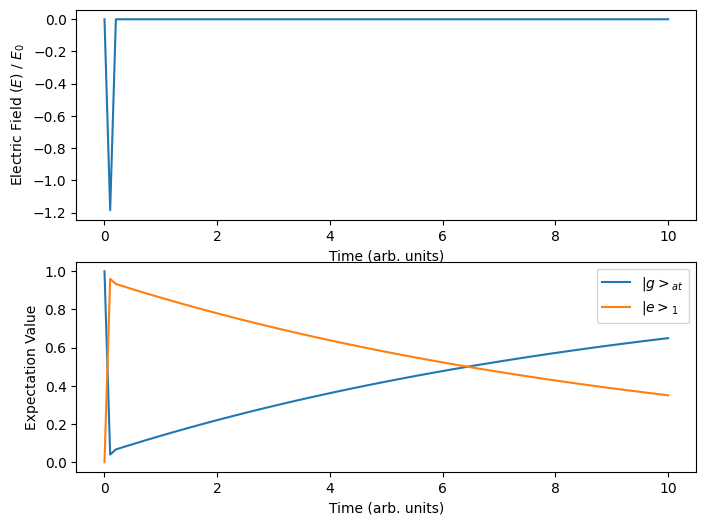

In [129]:
#
# PREPROCESSING
#
# Phase cycling
phases = [-1 * i * np.pi / 2 for i in range(4)]
data_dict_stage1 = {}
for phi in phases:
    data_dict_stage1[phi] = {}
#
# CALCULATIONS
#

# (first laser pulse)
times_0 = times_t

# Iterate over the phi values
for phi in data_dict_stage1:
    args_0 = {
        'phi': phi,  # Use the phase 0
        'time': Delta_ts[0],  # t0 value = Delta value such that the pulse immediatley starts
        'omega': omegas[0],  # omega value
        'Delta': Delta_ts[0], # The width should be
        'E0': Omegas[0]  # E0 value
    }
    # Solve the system using mesolve (first laser pulse)
    result_0 = mesolve(H, psiini, times_0, c_ops=c_op_list, e_ops=e_op_list, args=args_0, options=options)

    current_dict = {}

    for i in range(len(times_0)): # save only the states that make sense
        if (2 * Delta_ts[0] <= times_0[i] <= last_pulse - 2 * (Delta_ts[1] + Delta_ts[2])):
            current_dict[i] = result_0.states[i]  # tau is indirectly stored in the index i (key of the dictionary)
            #print(expect(Dip_op, result_0.states[i]))

    if current_dict:  # Check if the dictionary is not empty
        data_dict_stage1[phi] = current_dict

#
# PLOT TO CHECK the evolution
#

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(times_0, [El_field(t, args_0)/omega_R for t in times_0])
ax1.set_xlabel("Time (arb. units)")
ax1.set_ylabel("Electric Field ($E$) / $E_0$")
for i, e_op_expect in enumerate(result_0.expect):
    if i == 0:
        label = r"$|g>_{at}$"
    else:
        label = f"$|e>_{i}$"
    ax2.plot(result_0.times, e_op_expect, label=label)
ax2.set_xlabel("Time (arb. units)")
ax2.set_ylabel("Expectation Value")
ax2.legend()
plt.show()

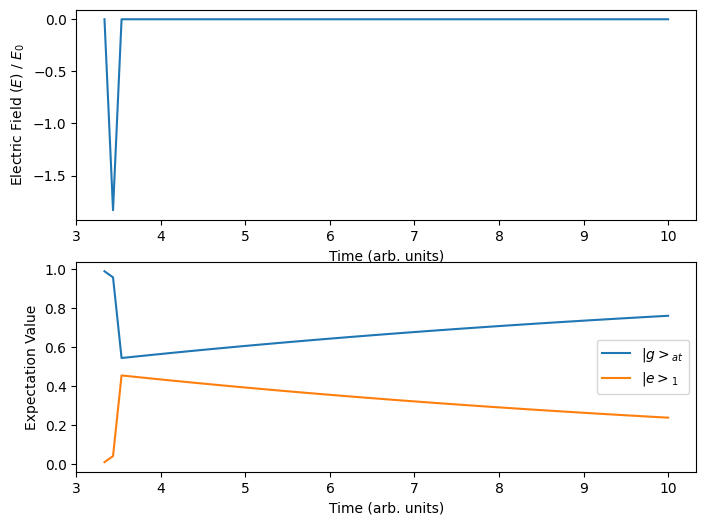

In [130]:
# (second laser pulse)
data_dict_stage2 = {}

# Iterate over the phi values
for phi, dic in data_dict_stage1.items():
    data_dict_stage2[phi] = {}  # Stage 2 copy of the phase
    # Iterate over the tau values and states after tau, from there make the second laser pulse
    for i, psiini_1 in dic.items():
        times_1 = times_t[i:]
        args_1 = {
            'phi': phi,
            'time': times_1[0] + Delta_ts[1],
            'omega': omegas[1],
            'Delta': Delta_ts[1],
            'E0': Omegas[1]
        }
        # Solve the system using mesolve (second laser pulse)
        result_1 = mesolve(H, psiini_1, times_1, c_ops=c_op_list, e_ops=e_op_list, args=args_1, options=options)

        current_dict = {}
        for j in range(len(times_1)): # save only the states that make sense
            if (times_t[i] + 2 * Delta_ts[1] <= times_1[j] <= last_pulse - 2 * Delta_ts[2]):
                current_dict[j] = result_1.states[j] # T is stored in the information j, together with i
                #print(expect(Dip_op, result_1.states[j]))

        if current_dict:  # Check if the dictionary is not empty
            data_dict_stage2[phi][i] = current_dict

        # Plot one example
        if phi == 0 and i == time_steps//3:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
            ax1.plot(times_1, [El_field(t, args_1)/omega_R for t in times_1])
            ax1.set_xlabel("Time (arb. units)")
            ax1.set_ylabel("Electric Field ($E$) / $E_0$")
            for i, e_op_expect in enumerate(result_1.expect):
                if i == 0:
                    label = r"$|g>_{at}$"
                else:
                    label = f"$|e>_{i}$"
                ax2.plot(result_1.times, e_op_expect, label=label)
            ax2.set_xlabel("Time (arb. units)")
            ax2.set_ylabel("Expectation Value")
            ax2.legend()
            plt.show()
#pprint.pprint(data_dict_stage2)

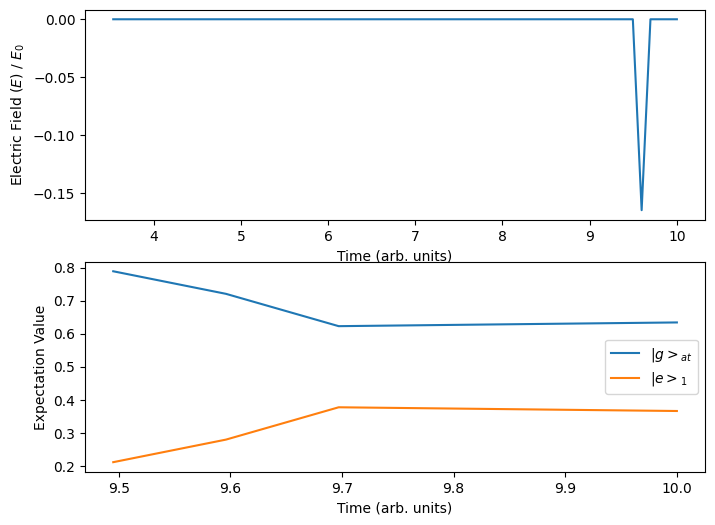

In [189]:
# (third laser pulse)
data_dict = {}

# Iterate over the phi values
for phi, dic in data_dict_stage2.items():
    if phi not in data_dict:
        data_dict[phi] = {}

    # Iterate over the tau values
    for i, dic1 in dic.items():
        times_1 = times_t[i:]
        # Iterate over the T values and make the last laser pulse
        count = 0
        for j, psiini_2 in dic1.items():
            T_j = times_1[j] + Delta_ts[2] - Delta_ts[1]
            # if the delay T is smaller than the current pulse difference, dont count it -> continue
            # if the delay T is bigger than the current pulse difference, -> continue
            if Ts[count] > T_j:
                continue

            # ONLY NOW MAKE THE LAST PULSE
            elif np.isclose(T_j, Ts[count]):

                # (last laser pulse)
                times_2 = times_1[j:]
                args_2 = {
                    'phi': 0,       #last pulse has no phase kick
                    'time': times_2[0] + Delta_ts[2],  # Duration for the 2nd pulse
                    'omega': omegas[2],  # Omega for the 2nd pulse
                    'Delta': Delta_ts[2],  # Delta for the 2nd pulse
                    'E0': Omegas[2]  # E0 for the 2nd pulse
                }
                result_2 = mesolve(H, psiini_2, times_2, c_ops=c_op_list, e_ops=e_op_list, args=args_2, options=options)

                # Iterate over the states in result_2 and store the ones that meet the condition below:
                for k in range(len(times_2)):
                    if (times_1[j] + 2 * Delta_ts[2] <= times_2[k] <= last_det_t):
    #                       print(expect(Dip_op, result_2.states[k]))
    #                        waiting_time_j = times_1[j] + Delta_ts[2] - Delta_ts[1]
    #                        coherence_time_i = times_0[i] + Delta_ts[1] - Delta_ts[0]
    #                        T = truncate_number(waiting_time_j, tolerance-2) # Round to tolearance decimal places carefull!
    #                        tau = truncate_number(coherence_time_i, tolerance-2) # Round to tolearance decimal places carefull!
    #                        detection_time_k = truncate_number(times_2[k] - times_2[0], tolerance-2)
                        tau = i
                        T = j
                        if T not in data_dict[phi]:
                            data_dict[phi][T_j] = {}

                        if tau not in data_dict[phi][T]:
                            data_dict[phi][T_j][tau] = []

                        # store the final time and the final state
                        t = k
                        data_dict[phi][T_j][tau].append((t, result_2.states[k], waiting_time_j, coherence_time_i, detection_time_k)) # Round to tolearance decimal places carefull!

                # Plot one example
                if phi == 0 and i == time_steps//3:
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
                    ax1.plot(times_2, [El_field(t, args_2)/omega_R for t in times_2])
                    ax1.set_xlabel("Time (arb. units)")
                    ax1.set_ylabel("Electric Field ($E$) / $E_0$")
                    for i, e_op_expect in enumerate(result_2.expect):
                        if i == 0:
                            label = r"$|g>_{at}$"
                        else:
                            label = f"$|e>_{i}$"
                        ax2.plot(result_2.times, e_op_expect, label=label)
                    ax2.set_xlabel("Time (arb. units)")
                    ax2.set_ylabel("Expectation Value")
                    ax2.legend()
                    plt.show()
                    continue

            count += 1


#pprint.pprint(data_dict)
# The final data_dict will now contain the results for each φ, τ, and T

In [157]:
for T, tau_dict in data_dict[phases[0]].items():
    print(tau_dict.keys())

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 1, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 1, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,

In [158]:
#
# POST-PROCESSING
#

# Create an empty dictionary `accumulated_data` to store lists of (\psi) for each ((\tau, T, t)):
averaged_data_dict = {}
for T, tau_dict in sorted(data_dict[phases[0]].items()):
    print(tau_dict.keys())
    if T not in averaged_data_dict:
        averaged_data_dict[T] = {}
    for tau, T_list in sorted(tau_dict.items()):
        if tau not in averaged_data_dict[T]:
            averaged_data_dict[T][tau] = {}

        for t, psi_mean, _, _, _ in T_list:
            if t not in averaged_data_dict[T][tau]:
                averaged_data_dict[T][tau][t] = None

            for phi in data_dict.keys():
                for T1 in data_dict[phi].keys():
                    if T1 == T:
                        for tau1 in data_dict[phi][T1].keys():
                            if tau1 == tau:
                                for t1, psi1, _, _, _  in data_dict[phi][T1][tau1]:
                                    if t1 == t:
                                        psi_mean += psi1
                                    continue
                            continue
                    continue
            expect_val = expect(Dip_op, psi_mean.unit())
            averaged_data_dict[T][tau][t] = expect_val
# <psi | Dip_op | psi>

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 1, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 1, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,

dict_items([(1, {2: -4.144135258219091, 3: -1.0807333296219506, 4: 2.2503826358808157, 5: 4.545826953144832, 6: 4.967540693682909, 7: 3.44447103639642, 8: 0.6623151252613431, 9: -2.2393388001825834, 10: -4.130749583762672, 11: -4.329100687932735, 12: -2.840953232212695, 13: -0.32575311249906236, 14: 2.1917391412696268, 15: 3.736345593423407, 16: 3.757731317748648, 17: 2.32263510535885, 18: 0.05862598429208395, 19: -2.116583839620635, 20: -3.36487502387903, 21: -3.248415960443409, 22: -1.879529706098083, 23: 0.14990864127229575, 24: 2.021331635546478, 25: 3.017690759599307, 26: 2.7961778352416435, 27: 1.5025705875943003, 28: -0.30929402729264005, 29: -1.9121268036757084, 30: -2.6954205673375844, 31: -2.3961567614751145, 32: -1.1835624873462272, 33: 0.4277222629424184, 34: 1.7939851343765298, 35: 2.398118195207126, 36: 2.0436678210618475, 37: 0.915129497444299, 38: -0.5122707294014832, 39: -1.6709588748002635, 40: -2.1253906242954965, 41: -1.7342435009305468, 42: -0.6906608324128579, 43:

In [160]:
#
# PREPARE FOR PLOTTING
#
T_dictionary = {}

for T in averaged_data_dict.keys():  # Extract all unique T values
    taus = np.array(list(averaged_data_dict[T].keys()))
    ts = np.array(sorted(set(t for tau in taus for t in averaged_data_dict[T][tau].keys())))
    data = np.zeros((len(ts), len(taus)))  # or dtype=np.complex128 if needed
    # Populate the 2D data array with the corresponding expect_vals
    for i, t in enumerate(ts):  # Iterate over ts
        for j, tau in enumerate(taus):  # Iterate over taus
            # Check if the specific t exists for the given tau
            if t in averaged_data_dict[T][tau]:
                data[i, j] = averaged_data_dict[T][tau][t]  # Assign expect_val

    # Store T-specific results in the dictionary
    T_dictionary[T] = {
        "ts": ts,      # Local ts specific to T
        "taus": taus,  # Local taus specific to T
        "data": data,  # Local data
    }

valid_indices = np.linspace(0, time_steps - 1, time_steps//3, dtype=int)  # Equally distributed indices

smallest_key = min(averaged_data_dict.keys())  # first T value gives biggest data-set
print(smallest_key)
global_ts = np.array(T_dictionary[smallest_key]["ts"])  # Local taus for the current T
global_taus = np.array(T_dictionary[smallest_key]["taus"])  # Local taus for the current T
print(global_taus, global_ts)

2
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95] [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


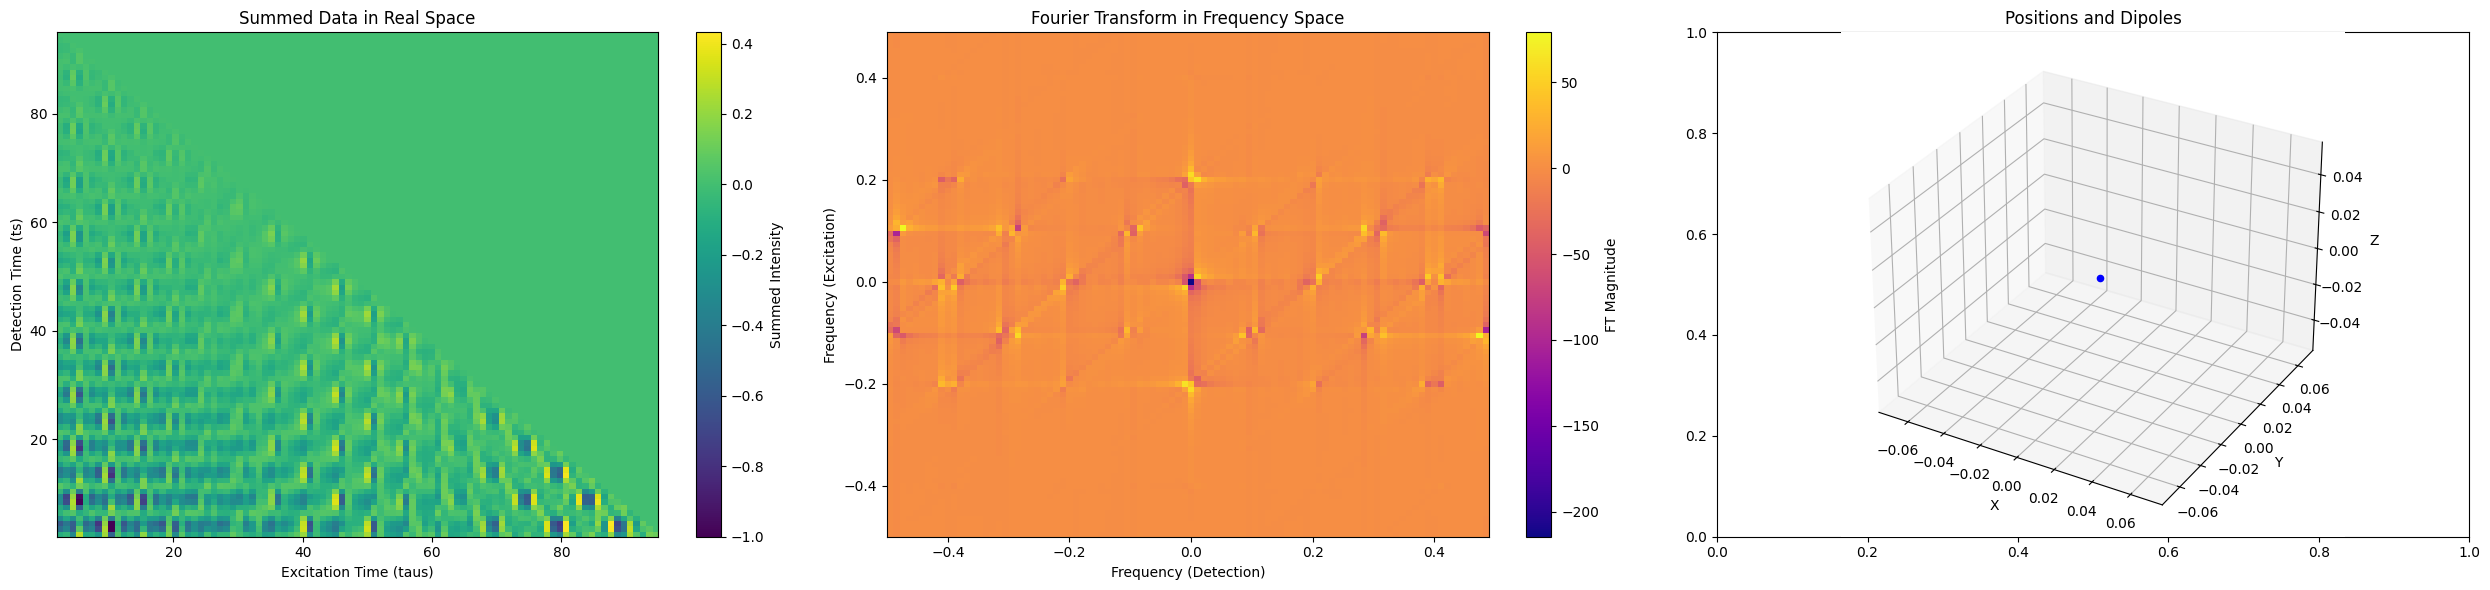

In [161]:
#
# PLOT THE WHOLE DATA AVG and its FT
#
# Sum all data into global sum
global_data = np.zeros((len(global_ts), len(global_taus)))

# Sum data for each temperature T in T_dictionary
for T, T_data in T_dictionary.items():
    ts = T_data["ts"]
    taus = T_data["taus"]
    data = T_data["data"]

    for i, t in enumerate(ts):
        for j, tau in enumerate(taus):
            global_i = np.where(global_ts == t)[0]  # Find the index of t in global_ts
            global_j = np.where(global_taus == tau)[0]
            global_data[global_i, global_j] += data[i, j]  # Accumulate (you can also do averaging if needed)
max = np.max(np.abs(global_data))
global_data /= max

# Perform 2D Fourier Transform
ft_data = np.fft.fft2(global_data)
ft_data = np.fft.fftshift(ft_data)  # Shift zero frequency to the center
freq_ts = np.fft.fftshift(np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0])))
freq_taus = np.fft.fftshift(np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0])))

epsilon = 1e-10  # Small value to avoid division by zero
#ft_data = -freq_ts[:, np.newaxis] * np.imag(
#    ft_data / (freq_taus[:, np.newaxis] + epsilon))
ft_data = np.real(ft_data)
max = np.max(np.abs(ft_data))
#ft_data /= max

fig, axs = plt.subplots(1, 3, figsize=(25, 6))

# Plot the global sum (2D plot) in the first subplot (axs[0])
extent = [np.min(global_taus), np.max(global_taus), np.min(global_ts), np.max(global_ts)]
im1 = axs[0].imshow(global_data, extent=extent, origin='lower', aspect='auto', cmap='viridis')
axs[0].set_title("Summed Data in Real Space")
axs[0].set_ylabel("Detection Time (ts)")
axs[0].set_xlabel("Excitation Time (taus)")
fig.colorbar(im1, ax=axs[0], label="Summed Intensity")

# Plot the Fourier Transform result (2D plot) in the second subplot (axs[1])
extent_ft = [np.min(freq_taus), np.max(freq_taus), np.min(freq_ts), np.max(freq_ts)]
im2 = axs[1].imshow(ft_data, extent=extent_ft, origin='lower', aspect='auto', cmap='plasma')
axs[1].set_title("Fourier Transform in Frequency Space")
axs[1].set_xlabel("Frequency (Detection)")
axs[1].set_ylabel("Frequency (Excitation)")
fig.colorbar(im2, ax=axs[1], label="FT Magnitude")
ax3d = fig.add_subplot(1, 3, 3, projection='3d')  # 3D plot in the third subplot
Pos = cyl_positions(distance, N_atoms, n_chains)
ax3d.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o')
ax3d.set_xlabel('X')
ax3d.set_ylabel('Y')
ax3d.set_zlabel('Z')
ax3d.set_title('Positions and Dipoles')
ax3d.axis('equal')
plt.tight_layout()
file_name_combined = f"Classical_REAL_+_FT_lam{fixed_lam:.1f}_alpha={alpha:.2f}_g_0{gamma_0:.2f}_g_phi{gamma_phi:.2f}_{n_rings}x{n_chains}_dist={distance:.2f}.svg"
save_path_combined = "/home/leopold/PycharmProjects/Master_thesis/Figures_From_Python/" + file_name_combined
#plt.savefig(save_path_combined)
plt.show()

In [ ]:
#
# PLOT THE TIME DIMENSIONS ON A GLOBAL GRID
#
T_dictionary_full = {} # save the extended time dim. data in new dict
for idx, (T, T_data) in enumerate(T_dictionary.items()):
    if idx not in valid_indices:  # Ensure only valid indices are selected
        continue
    # Extract data for the current T
    taus = T_data["taus"]  # Local taus for the current T
    ts = T_data["ts"]  # Local ts for the current T
    data = T_data["data"]  # Aligned 2D data
    if len(ts) < 2 or len(taus) < 2:  # Ensure only valid indices are selected
        continue

    # Initialize the global extended grid with zeros
    data_extended = np.zeros((len(global_ts), len(global_taus)))

    # Map taus and ts to global indices
    for i, t in enumerate(ts):
        for j, tau in enumerate(taus):
            global_i = np.where(global_ts == t)[0]  # Find the index of t in global_ts
            global_j = np.where(global_taus == tau)[0]
            data_extended[global_i, global_j] = data[i, j]  # Accumulate (you can also do averaging if needed)
    max = np.max(np.abs(data_extended))
    data_extended /= max

#    plt.figure(figsize=(10, 8))
#    # Define extent for axis alignment (using the global ts and taus)
#    extent = [global_ts[0], global_ts[-1], global_taus[0], global_taus[-1]]
#    plt.imshow(data_extended, extent=extent, origin='lower', aspect='auto', cmap='viridis')
#    plt.colorbar(label="Expectation Value (Intensity)")
#    plt.title(f"2D Real Space for T={T:.2f}")
#    plt.xlabel("Detection Time (ts)")
#    plt.ylabel("Excitation Time (taus)")
#    plt.show()
    T_dictionary_full[T] = {"data": data_extended}
########################################################33333333 REAL SPACE END

In [ ]:
summed_A = 0
#
# PLOT THE GLOBAL DATA IN FREQUENCY SPACE AND THE SUM
#
global_t_freqs = np.fft.fftshift(np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0])))  # Frequency axis for detection time
global_tau_freqs = np.fft.fftshift(np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0])))  # Frequency axis for excitation time
#global_t_freqs = global_t_freqs[len(global_ts) // 2:]
#global_tau_freqs = global_tau_freqs[len(global_taus) // 2:]

for idx, (T, T_data) in enumerate(T_dictionary_full.items()):
    if idx not in valid_indices:  # Ensure only valid indices are selected
        continue
    data = T_data["data"]  # Aligned 2D data
    if len(ts) < 2 or len(taus) < 2:  # Ensure meaningful dimensions
        continue
    # Compute 2D Fourier Transform on the `data` array
    FT_data = np.fft.fft2(data)
    FT_data = np.fft.fftshift(FT_data)
#    FT_data = FT_data[len(global_ts) // 2:, len(global_taus) // 2:]

    # Extract the subset of FT_data corresponding to positive frequencies
    epsilon = 1e-10  # Small value to avoid division by zero
    A = np.abs(FT_data)#-global_t_freqs[:, np.newaxis] * np.imag(
#        FT_data / (freq_taus[:, np.newaxis] + epsilon))
    max = np.max(np.abs(A))

    # Plot the result using imshow
    plt.figure(figsize=(10, 8))

    # Define extent based on positive frequency ranges
    extent = [global_tau_freqs.min(), global_tau_freqs.max(), global_t_freqs.min(), global_t_freqs.max()]

    # Visualize the normalized A as an image
    plt.imshow(A / max, extent=extent, origin='lower', aspect='auto', cmap='plasma')

    # Add colorbar to show intensity values
    plt.colorbar(label="Intensity")

    # Add title and axis labels
    plt.title(f"2D Spectroscopy Fourier Transform for T={T:.2f}")
    plt.ylabel("$\omega_{exc}$ (arb. units)")  # Excitation frequency
    plt.xlabel("$\omega_{det}$ (arb. units)")  # Detection frequency

    # Show the plot
    plt.show()    # Plot the result using imshow

    summed_A += A

max = np.max(np.abs(summed_A))
summed_A /= max
plt.figure(figsize=(10, 8))
extent = [np.min(global_tau_freqs), np.max(global_tau_freqs), np.min(global_t_freqs), np.max(global_t_freqs)]
plt.imshow(summed_A, extent=extent, origin='lower', aspect='auto', cmap='plasma')
plt.colorbar()
plt.title("SUMMED 2D Spectroscopy")
plt.ylabel("$\omega_{exc}$ (arb. units)")
plt.xlabel("$\omega_{det}$ (arb. units)")
file_name_combined = f"Classical_Summed_in_freq_space__plot_lam{fixed_lam:.1f}_alpha={alpha:.2f}_g_0{gamma_0:.2f}_g_phi{gamma_phi:.2f}_{n_rings}x{n_chains}_dist={distance:.2f}.svg"
save_path_combined = "/home/leopold/PycharmProjects/Master_thesis/Figures_From_Python/" + file_name_combined
plt.savefig(save_path_combined)
plt.show()

In [ ]:
#
# ONLY PLOT THE LOCAL, POSITIVE PARTS OF THE DATA IN FREQUENCY SPACE
#
for idx, (T, T_data) in enumerate(T_dictionary.items()):
    if idx not in valid_indices:  # Ensure only valid indices are selected
        continue

    # Extract data for the current T
    taus = T_data["taus"]  # Local taus for the current T
    ts = T_data["ts"]  # Local ts for the current T
    data = T_data["data"]  # Aligned 2D data

    if len(ts) < 2 or len(taus) < 2:  # Ensure meaningful dimensions
        continue

    # Compute 2D Fourier Transform on the `data` array
    FT_data = np.fft.fft2(data)
    FT_data = np.fft.fftshift(FT_data)

    # Calculate frequency axes for ts and taus
    t_freqs = np.fft.fftfreq(len(ts), d=(ts[1] - ts[0]))  # Frequency axis for detection time
    tau_freqs = np.fft.fftfreq(len(taus), d=(taus[1] - taus[0]))  # Frequency axis for excitation time
    t_freqs = np.fft.fftshift(np.fft.fftfreq(len(ts), d=(ts[1] - ts[0])))
    tau_freqs = np.fft.fftshift(np.fft.fftfreq(len(taus), d=(taus[1] - taus[0])))


    positive_t_indices = np.where(t_freqs >= 0)
    positive_tau_indices = np.where(tau_freqs >= 0)
    t_freqs_positive = t_freqs[positive_t_indices]
    tau_freqs_positive = tau_freqs[positive_tau_indices]

    if len(positive_t_indices[0]) < 2 or len(positive_tau_indices[0]) < 2:  # Ensure meaningful dimensions
        continue

    epsilon = 1e-10  # Small value to avoid division by zero
    # Extract the subset of FT_data corresponding to positive frequencies
    A_positive = -t_freqs_positive[:, np.newaxis] * np.imag(
        FT_data[np.ix_(positive_t_indices[0], positive_tau_indices[0])]
        / (tau_freqs_positive[:, np.newaxis] + epsilon))
    # Normalize A for better visualization
    max_abs_A = np.max(np.abs(A_positive))
    if max_abs_A != 0:  # Avoid division by zero
        A_positive = A_positive / max_abs_A


    # Plot the result using imshow
    plt.figure(figsize=(8, 6))

    # Define extent based on positive frequency ranges
    extent = [tau_freqs_positive.min(), tau_freqs_positive.max(), t_freqs_positive.min(), t_freqs_positive.max()]

    # Visualize the normalized A as an image
    plt.imshow(A_positive, extent=extent, origin='lower', aspect='auto', cmap='plasma')

    # Add colorbar to show intensity values
    plt.colorbar(label="Intensity")

    # Add title and axis labels
    plt.title(f"2D Spectroscopy Fourier Transform for T={T:.2f} (Positive Frequencies)")
    plt.xlabel("$\omega_{exc}$ (arb. units)")  # Excitation frequency
    plt.ylabel("$\omega_{det}$ (arb. units)")  # Detection frequency

    # Show the plot
    plt.show()

In [ ]:
#
# PLOT THE LOCAL PARTS OF THE DATA IN FREQUENCY SPACE
#
for idx, (T, T_data) in enumerate(T_dictionary.items()):
    if idx not in valid_indices:  # Ensure only valid indices are selected
        continue

    # Extract data for the current T
    taus = T_data["taus"]  # Local taus for the current T
    ts = T_data["ts"]  # Local ts for the current T
    data = T_data["data"]  # Aligned 2D data

    if len(ts) < 2 or len(taus) < 2:  # Ensure meaningful dimensions
        continue

    # Compute 2D Fourier Transform on the `data` array
    FT_data = np.fft.fft2(data)
    FT_data = np.fft.fftshift(FT_data)

    # Calculate frequency axes for ts and taus
    t_freqs = np.fft.fftshift(np.fft.fftfreq(len(ts), d=(ts[1] - ts[0])))
    tau_freqs = np.fft.fftshift(np.fft.fftfreq(len(taus), d=(taus[1] - taus[0])))
    # Extract the subset of FT_data corresponding to positive frequencies
    A = -t_freqs[:, np.newaxis] * np.imag(
        FT_data)
#    # Normalize A for better visualization
#    max_abs_A = np.max(np.abs(A))
#    if max_abs_A != 0:  # Avoid division by zero
#        A = A / max_abs_A


    # Plot the result using imshow
    plt.figure(figsize=(8, 6))

    # Define extent based on positive frequency ranges
    extent = [tau_freqs.min(), tau_freqs.max(), t_freqs.min(), t_freqs.max()]

    # Visualize the normalized A as an image
    plt.imshow(A, extent=extent, origin='lower', aspect='auto', cmap='plasma')

    # Add colorbar to show intensity values
    plt.colorbar(label="Intensity")

    # Add title and axis labels
    plt.title(f"2D Spectroscopy Fourier Transform for T={T:.2f}")
    plt.xlabel("$\omega_{exc}$ (arb. units)")  # Excitation frequency
    plt.ylabel("$\omega_{det}$ (arb. units)")  # Detection frequency

    # Show the plot
    plt.show()

In [ ]:
#
#  SOME TESTS
#  I HAVE TO DO A transpose A.T
#
freq_ts = np.array([0.1, 0.2])  # Frequency (Detection) axis
freq_taus = np.array([0.3, 0.4, 1, 2, 3, 4, 8])  # Frequency (Excitation) axis
ft_data = np.array([[1, 2, 3, 4, 5, 6, 7],
                    [3, 4, 0, 0, 0, 0, 0]])
data = np.zeros((len(freq_ts), len(freq_taus)), dtype=np.float64)
for i, t in enumerate(freq_ts):  # Iterate over detection frequencies (ts)
    for j, tau in enumerate(freq_taus):  # Iterate over excitation frequencies (taus)
        data[i, j] = ft_data[i, j]  # Assign expect_val
#print(ft_data.shape)

# Plotting without transpose
plt.figure(figsize=(10, 8))
plt.imshow(data, origin='lower', cmap='plasma')
plt.colorbar(label="FT Magnitude")
plt.title("Fourier Transform (Without Transpose)")
plt.xlabel("Frequency (Detection)")
plt.ylabel("Frequency (Excitation)")
plt.show()

In [ ]:
# Parameters for the Gaussian function
A = 1  # Amplitude
mu_x = 0  # Mean in x direction
mu_y = 0  # Mean in y direction
sigma_x = 2  # Standard deviation in x direction
sigma_y = 2  # Standard deviation in y direction

# Define the range and resolution for x and y
x_vals = np.linspace(-5, 5, 100)  # x values from -5 to 5 with 100 points
y_vals = np.linspace(-5, 5, 100)  # y values from -5 to 5 with 100 points

# Create a meshgrid for x and y values
x, y = np.meshgrid(x_vals, y_vals)

# Define the 2D Gaussian function
z = A * np.exp(-((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2)))
for i in range(len(x_vals)):
    for j in range(len(y_vals)):
        if i < j:
            z[i, j] = 0
# Perform the 2D Fourier Transform
z_ft = np.fft.fft2(z)

# Shift the zero-frequency component to the center
z_ft_shifted = np.fft.fftshift(z_ft)

# Calculate the magnitude and phase of the Fourier Transform
magnitude = np.abs(z_ft_shifted)
phase = np.angle(z_ft_shifted)

# Plotting the original 2D Gaussian and its Fourier Transform
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot the original 2D Gaussian
axs[0].imshow(z, extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]], cmap='viridis')
axs[0].set_title('2D Gaussian (Real Space)')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

# Plot the magnitude of the Fourier Transform (frequency space)
axs[1].imshow(np.log(magnitude + 1e-5), extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]], cmap='viridis')  # log scale for visibility
axs[1].set_title('Fourier Transform (Magnitude, Frequency Space)')
axs[1].set_xlabel('Frequency X')
axs[1].set_ylabel('Frequency Y')
plt.tight_layout()
plt.show()